## Step 1: Setup and Imports
We import:
- `math` for cosine calculation,
- `random` to introduce stochasticity,
- `matplotlib.pyplot` to plot results.

In [163]:
import torch
import math
import random
import numpy as np
import matplotlib.pyplot as plt

## Step 2: Define the Function
This is our toy non-convex function:

$f(x) = x^4 - 2x^2 + 0.25x$

It has two minima: a **global minimum** on the left and a **local minimum** on the right.


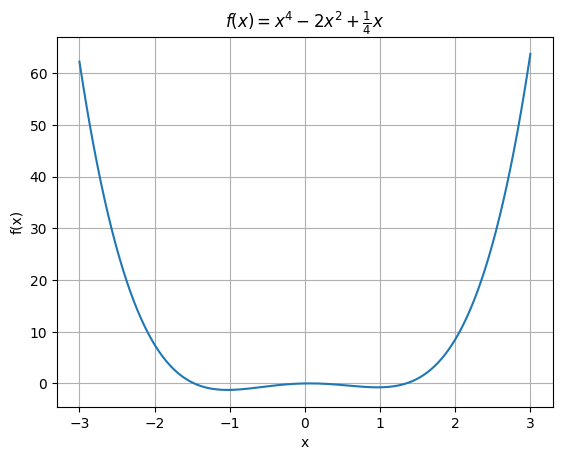

In [164]:
# Define the function
def f(x):
    return x**4 - 2*x**2 + 0.25*x

# Plot
x_vals = np.linspace(-3, 3, 500)
y_vals = f(x_vals)

plt.plot(x_vals, y_vals)
plt.title(r"$f(x) = x^4 - 2x^2 + \frac{1}{4}x$")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()


## Step 3: Stochastic Gradient
Instead of using the full gradient, we randomly pick one part of the function:
- $ x^4 \rightarrow 4x^3 $
- $ -2x^2 \rightarrow -4x $
- $ 0.25x \rightarrow 0.25 $
  
This adds randomness to help escape local minima.


In [165]:
# Function to return the gradient of a randomly selected component
def stochastic_gradient(x):
    choice = random.randint(0, 2)
    if choice == 0:     # Gradient of x^4
        return 4 * x**3
    elif choice == 1:   # Gradient of -2x^2
        return -4 * x
    else:               # Gradient of 0.25x
        return 0.25

## Step 4: Cosine Annealing Learning Rate
We let the learning rate oscillate between 0.01 and 0.05 every T=10 steps.
This helps with exploring the function better.

In [166]:
# Cosine annealing learning rate
def cosine_lr(k, T=10, lr_min=0.01, lr_max=0.05):
    cycle_pos = k % T
    cosine = math.cos(math.pi * cycle_pos / T)
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + cosine)

## Step 5: Method 1 -- Cosine-Annealed SGD
We apply stochastic gradient descent with cosine-annealed learning rate.
- We track the values of x at each step.
- We also store the learning rate used at each step.


In [167]:
# Run cosine annealed SGD
def run_sgd_cosine(x0=1.1, steps=100):
    x = x0
    x_list = [x]
    lr_list = []

    for k in range(steps):
        lr = cosine_lr(k)
        grad = stochastic_gradient(x)
        x = x - lr * grad

        x_list.append(x)
        lr_list.append(lr)
    
    return x_list, lr_list

## Step 6: Plot Results
- The **left plot** shows how x evolves over time.
- The **right plot** shows the cosine-based learning rate pattern.

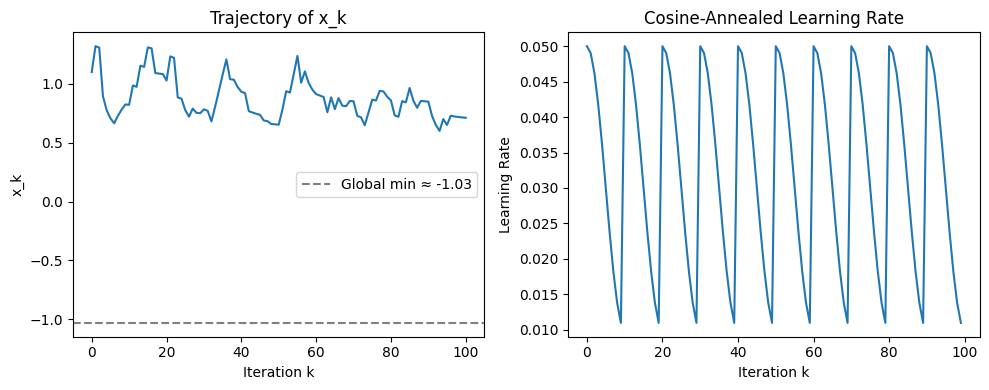

In [168]:
# Run the optimizer
trajectory, lrs = run_sgd_cosine()

# Plot the x_k trajectory
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(trajectory)
plt.title("Trajectory of x_k")
plt.xlabel("Iteration k")
plt.ylabel("x_k")
plt.axhline(-1.03, linestyle="--", color="gray", label="Global min ≈ -1.03")
plt.legend()

# Plot the learning rate path
plt.subplot(1, 2, 2)
plt.plot(lrs)
plt.title("Cosine-Annealed Learning Rate")
plt.xlabel("Iteration k")
plt.ylabel("Learning Rate")
plt.tight_layout()
plt.show()

## Step 7: Method 2 -- SGD with $\frac{1}{k}$ Learning Rate

In [169]:
def run_sgd_decay(x0=1.1, steps=100):
    x = x0
    x_list = [x]
    for k in range(steps):
        lr = 0.05 / (k + 1)
        grad = stochastic_gradient(x)
        x = x - lr * grad
        x_list.append(x)
    return x_list

## Step 8: Method 3 -- Standard Gradient Descent

In [170]:
def run_gd_constant(x0=1.1, steps=100, lr=0.02):
    x = x0
    x_list = [x]
    for _ in range(steps):
        grad = 4 * x**3 - 4 * x + 0.25  # full gradient
        x = x - lr * grad
        x_list.append(x)
    return x_list

In [171]:
print(type(cosine_traj), len(cosine_traj))
print(type(decay_traj), len(decay_traj))
print(type(gd_traj), len(gd_traj))

<class 'list'> 101
<class 'list'> 101
<class 'list'> 101


## Step 9: Polt All 3 Trajectories

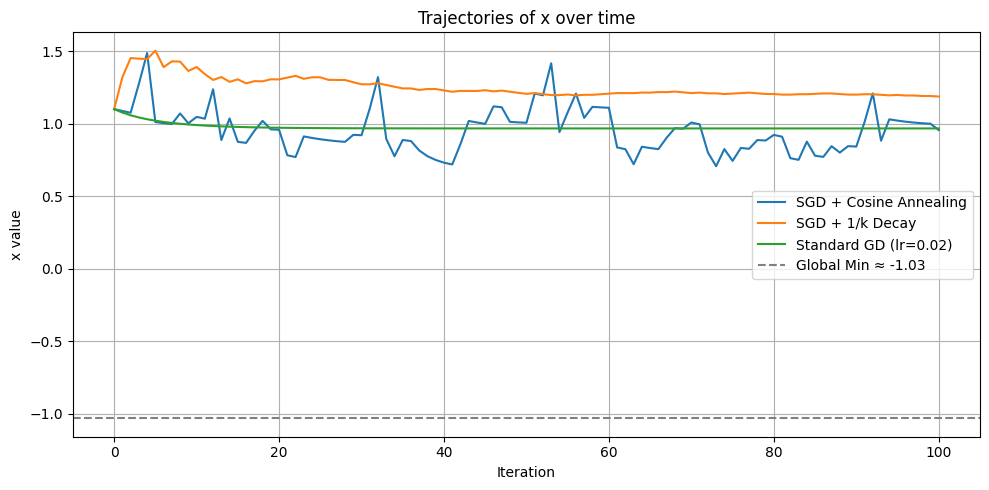

In [172]:
cosine_traj, _ = run_sgd_cosine()
decay_traj  = run_sgd_decay()
gd_traj     = run_gd_constant()

plt.figure(figsize=(10, 5))
plt.plot(range(len(cosine_traj)), cosine_traj, label='SGD + Cosine Annealing')
plt.plot(range(len(decay_traj)),  decay_traj,  label='SGD + 1/k Decay')
plt.plot(range(len(gd_traj)),     gd_traj,     label='Standard GD (lr=0.02)')
plt.axhline(-1.03, linestyle='--', color='gray', label='Global Min ≈ -1.03')
plt.xlabel("Iteration")
plt.ylabel("x value")
plt.title("Trajectories of x over time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 10: Measure Success Rate
We run the SGD multiple times and check if `x_k` ever goes below `-0.3`.
That means it entered the left well (where the global minimum lies).

In [173]:
def success_rate(runner, trials=100, threshold=-0.3):
    success = 0
    for _ in range(trials):
        result = runner()
        xs = result[0] if isinstance(result, tuple) else result
        if min(xs) < threshold:
            success += 1
    return success / trials

cosine_rate = success_rate(run_sgd_cosine)
decay_rate  = success_rate(run_sgd_decay)
gd_rate     = success_rate(run_gd_constant)

print(f"Cosine-Annealed SGD:     {cosine_rate:.2f}")
print(f"SGD with 1/k Decay:      {decay_rate:.2f}")
print(f"Standard GD (lr=0.02):   {gd_rate:.2f}")

Cosine-Annealed SGD:     0.02
SGD with 1/k Decay:      0.00
Standard GD (lr=0.02):   0.00
